In [2]:
! pip install numpy pandas matplotlib wordcloud nltk scikit-learn textblob gensim imblearn demoji tensorflow keras seaborn transformers torch

# 1. Import dataset e Preprocessing

In [4]:
# Importare le librerie necessarie
import pandas as pd
import re
import nltk
import demoji
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Scaricare le risorse di NLTK e Demoji
nltk.download('punkt_tab') #tokenizzazione
nltk.download('stopwords') # stop words
nltk.download('wordnet') # lemmatizzazione
demoji.download_codes() # dizionario delle emoji

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreaiasenzaniro/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaiasenzaniro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreaiasenzaniro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/_y/cszqss6n29q_h8m3vt4b2lk80000gn/T/ipykernel_39733/838186373.py:17: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes() # dizionario delle emoji


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Verifichaimo se ci sono valori NaN nei commenti. Se sono pochi rimuoviamo le righe associate.

# Caricare il dataset (modifica il percorso se necessario)
file_path = "datasets/YoutubeCommentsDataSet.csv"
df = pd.read_csv(file_path)

# Controlla se ci sono valori NaN nella colonna "Comment"
print(f"Numero totale di commenti prima della rimozione: {len(df)}")
print(f"Valori NaN nella colonna Comment: {df['Comment'].isna().sum()}")

# Se ci sono NaN, rimuoverli
df = df.dropna(subset=['Comment'])
print(f"Numero totale di commenti dopo la rimozione: {len(df)}")

df.head()

Numero totale di commenti prima della rimozione: 18408
Valori NaN nella colonna Comment: 44
Numero totale di commenti dopo la rimozione: 18364


,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


## Preprocessing dataset

In [5]:
# =========================
# **1️⃣ Espansione delle contrazioni**
# =========================
CONTRACTIONS_DICT = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "won't": "will not", "can't": "cannot", "i'm": "i am", "you're": "you are",
    "it's": "it is", "they're": "they are", "we're": "we are", "isn't": "is not",
    "aren't": "are not", "haven't": "have not", "hasn't": "has not",
    "wasn't": "was not", "weren't": "were not", "shouldn't": "should not",
    "wouldn't": "would not", "couldn't": "could not", "mustn't": "must not"
}

def expand_contractions(text):
    """Espande le contrazioni in testo normale (es. "don't" diventa "do not")."""
    for key, value in CONTRACTIONS_DICT.items():
        text = re.sub(r"\b" + key + r"\b", value, text)
    return text

# =========================
# **2️⃣ Correzione ortografica**
# =========================
def correct_spelling(text):
    """Corregge gli errori ortografici usando TextBlob."""
    return str(TextBlob(text).correct())

# =========================
# **3️⃣ Segmentazione delle frasi**
# =========================
def segment_sentences(text):
    """Divide il testo in frasi separate."""
    return sent_tokenize(text) if isinstance(text, str) else []

# =========================
# **4️⃣ Gestione delle emoji**
# =========================
EMOJI_DICT = {
    "😊": "happy", "😂": "laugh", "😢": "sad", "😡": "angry", "😍": "love",
    "😎": "cool", "👍": "positive", "👎": "negative", "🔥": "exciting",
    "🚀": "fast", "🎉": "celebration", "💯": "perfect", "🙏": "thankful",
    "🤔": "thinking", "😭": "crying", "😴": "sleepy", "😆": "funny",
    "🥳": "party", "💪": "strong", "🤗": "hug", "🥺": "emotional", "❤️": "love",
    "💔": "heartbroken", "😜": "playful", "🤩": "amazed", "🤬": "furious",
    "🤯": "mindblown", "😇": "innocent", "🙌": "cheer", "😐": "neutral",
    "👀": "looking", "🤓": "nerd", "🤤": "drooling", "🤡": "clown",
}

def replace_emojis(text):
    """Sostituisce le emoji con il loro significato testuale."""
    for emoji, meaning in EMOJI_DICT.items():
        text = text.replace(emoji, f" {meaning} ")
    return demoji.replace(text, lambda x: f" {demoji.replace(x)} ")

important_stopwords = {"not", "no", "nor", "n't", "never", "hardly", "barely", "scarcely",
                       "very", "really", "so", "extremely", "super", "terribly", "horribly",
                       "awfully", "slightly", "somewhat", "but", "however", "although",
                       "though", "yet", "i", "we", "you", "he", "she", "they", "my", "your",
                       "why", "how", "what"}

# =========================
# **5️⃣ Funzione di Preprocessing Generale**
# =========================
def preprocess_text(text):
    """Esegue il preprocessing completo di un testo."""
    if isinstance(text, str):
        # 1. Converti il testo in minuscolo
        text = text.lower()

        # 2. Espansione delle contrazioni
        text = expand_contractions(text)

        # 3. Rimozione di URL e menzioni (@username, #hashtag)
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        text = re.sub(r"@\w+|#\w+", "", text)

        # 4. Gestione delle emoji e simboli
        text = replace_emojis(text)

        # 5. Rimozione di caratteri speciali e markup
        text = re.sub(r"[^a-z\s]", "", text)

        # 6. Tokenizzazione con TweetTokenizer
        tokenizer = TweetTokenizer()
        tokens = tokenizer.tokenize(text)

        # 7. Rimozione delle stop words
        stop_words = set(stopwords.words("english")) - important_stopwords
        tokens = [word for word in tokens if word not in stop_words]

        # 8. Lemmatizzazione
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # 9. Correzione ortografica
        text = correct_spelling(" ".join(tokens))

        return text
    return ""

In [ ]:
# Applicazione del preprocessamento e della segmentazione
df['Segmented_Comments'] = df['Comment'].apply(segment_sentences)
df['Processed_Comment'] = df['Comment'].apply(preprocess_text)

# Visualizzare alcune righe del dataset preprocessato
df.head()

,Comment,Sentiment,Segmented_Comments,Processed_Comment
0,lets not forget that apple pay in 2014 require...,neutral,[lets not forget that apple pay in 2014 requir...,let not forget apple pay required brand new ph...
1,here in nz 50 of retailers don’t even have con...,negative,[here in nz 50 of retailers don’t even have co...,no retailer dont even contactless credit card ...
2,i will forever acknowledge this channel with t...,positive,[i will forever acknowledge this channel with ...,i forever acknowledge channel help your lesson...
3,whenever i go to a place that doesn’t take app...,negative,[whenever i go to a place that doesn’t take ap...,whenever i go place doesn take apple pay doesn...
4,apple pay is so convenient secure and easy to ...,positive,[apple pay is so convenient secure and easy to...,apple pay so convenient secure easy use i used...


## Visualizzazione esplorativa con Word Cloud

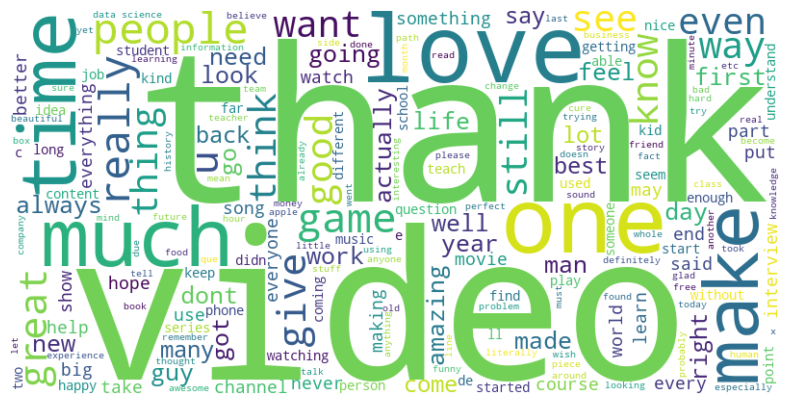

In [ ]:
all_words = ' '.join([str(text) for text in df['Processed_Comment']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Analisi del sentimento
Utilizziamo la libreria TextBlob per calcolare la polarità e la soggettività dei commenti.

                                   Processed_Comment  sentiment_score
0  let not forget apple pay required brand new ph...         0.075606
1  no retailer dont even contactless credit card ...         0.160000
2  i forever acknowledge channel help your lesson...         0.000000
3  whenever i go place doesn take apple pay doesn...        -0.227778
4  apple pay so convenient secure easy use i used...         0.208333


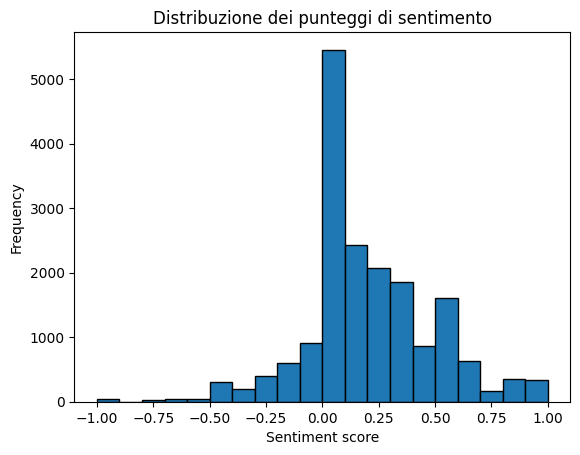

In [ ]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Polarità [-1, 1]

# Applicare la funzione al dataset
df['sentiment_score'] = df['Processed_Comment'].apply(get_sentiment)

# Visualizzare i primi risultati
print(df[['Processed_Comment', 'sentiment_score']].head())

# Distribuzione dei punteggi di sentimento
plt.hist(df['sentiment_score'], bins=20, edgecolor='black')
plt.title('Distribuzione dei punteggi di sentimento')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.show()

## Salvataggio dataset preprocessato su file

In [ ]:
# Salvataggio del dataset preprocessato in formato Pickle
df.to_pickle("datasets/Preprocessed_YoutubeComments.pkl")
print("Dataset salvato in formato Pickle!")

Dataset salvato in formato Pickle!


## Caricamento dataset preprocessato

In [ ]:
# Caricamento del dataset preprocessato da Pickle
#path_pickle = "/content/drive/MyDrive/NLPDataset/Preprocessed_YoutubeComments.pkl"
path_pickle = "datasets/Preprocessed_YoutubeComments.pkl"#

df = pd.read_pickle(path_pickle)
df.head()

,Comment,Sentiment,Segmented_Comments,Processed_Comment
0,lets not forget that apple pay in 2014 require...,neutral,[lets not forget that apple pay in 2014 requir...,let not forget apple pay required brand new ph...
1,here in nz 50 of retailers don’t even have con...,negative,[here in nz 50 of retailers don’t even have co...,no retailer dont even contactless credit card ...
2,i will forever acknowledge this channel with t...,positive,[i will forever acknowledge this channel with ...,i forever acknowledge channel help your lesson...
3,whenever i go to a place that doesn’t take app...,negative,[whenever i go to a place that doesn’t take ap...,whenever i go place doesn take apple pay doesn...
4,apple pay is so convenient secure and easy to ...,positive,[apple pay is so convenient secure and easy to...,apple pay so convenient secure easy use i used...


🔹 Distribuzione delle classi nel dataset:
Sentiment
positive    11402
neutral      4625
negative     2337
Name: count, dtype: int64


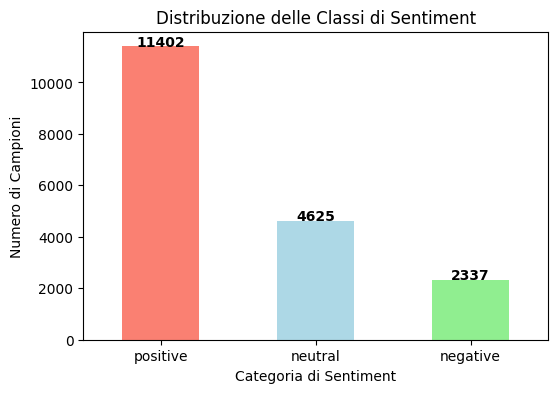

In [7]:
# =========================
# Distribuzione delle classi nel dataset
# =========================

class_distribution = df['Sentiment'].value_counts()

class_distribution

# 📌 Stampa la distribuzione numerica
print("🔹 Distribuzione delle classi nel dataset:")
print(class_distribution)

# 📌 Visualizzazione della distribuzione con un grafico a barre
plt.figure(figsize=(6, 4))
class_distribution.plot(kind='bar', color=['salmon', 'lightblue', 'lightgreen'])
plt.title("Distribuzione delle Classi di Sentiment")
plt.xlabel("Categoria di Sentiment")
plt.ylabel("Numero di Campioni")

# 📌 Aggiungere i numeri sopra le barre
for index, value in enumerate(class_distribution):
    plt.text(index, value + 5, str(value), ha='center', fontsize=10, fontweight='bold')

plt.xticks(rotation=0)
plt.show()

# 2. Machine Learning

## TF-IDF

🔹 Distribuzione classi PRIMA del bilanciamento:
Sentiment
positive    11402
neutral      4625
negative     2337
Name: count, dtype: int64

🔹 Distribuzione classi DOPO il bilanciamento:
Sentiment
negative    5000
neutral     5000
positive    5000
Name: count, dtype: int64


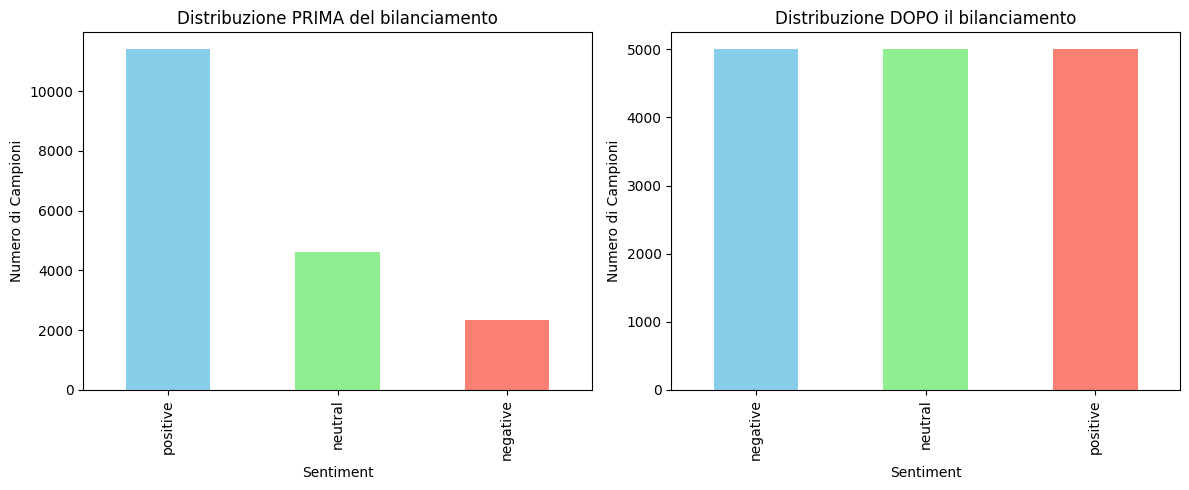


🔹 Dimensione Training Set: (12000, 15000)
🔹 Dimensione Test Set: (3000, 15000)


In [8]:
# =========================
# Bilanciamento delle Classi e TF-IDF per Sentiment Analysis
# =========================
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# 📌 Convertire il testo in TF-IDF
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,3))  # Include unigrammi, bigrammi e trigrammi
X_tfidf = tfidf.fit_transform(df['Processed_Comment'])

# 📌 Stampare la distribuzione delle classi PRIMA del bilanciamento
print("🔹 Distribuzione classi PRIMA del bilanciamento:")
print(df['Sentiment'].value_counts())

# 📌 1️⃣ **Downsampling della classe positiva**
# Riduciamo 'positive' a un numero intermedio, ad esempio 5000
under_sampler = RandomUnderSampler(sampling_strategy={'positive': 5000}, random_state=42)
X_under, y_under = under_sampler.fit_resample(X_tfidf, df['Sentiment'])

# 📌 2️⃣ **Upsampling delle classi negative e neutrali con SMOTE**
# Portiamo 'negative' e 'neutral' a circa 5000 ciascuno
smote = SMOTE(sampling_strategy={'negative': 5000, 'neutral': 5000}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

# 📌 Stampare la distribuzione delle classi DOPO il bilanciamento
print("\n🔹 Distribuzione classi DOPO il bilanciamento:")
print(pd.Series(y_balanced).value_counts())

# 📌 Divisione in training e test set
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# 📌 Visualizzazione della distribuzione prima e dopo il bilanciamento
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 📌 Grafico PRIMA del bilanciamento
df['Sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'], ax=axes[0])
axes[0].set_title('Distribuzione PRIMA del bilanciamento')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Numero di Campioni')

# 📌 Grafico DOPO il bilanciamento
pd.Series(y_balanced).value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'], ax=axes[1])
axes[1].set_title('Distribuzione DOPO il bilanciamento')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Numero di Campioni')

plt.tight_layout()
plt.show()

# 📌 Stampare le dimensioni finali dei dataset
print(f"\n🔹 Dimensione Training Set: {X_train_sent.shape}")
print(f"🔹 Dimensione Test Set: {X_test_sent.shape}")

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV

# 📌 Normalizzazione per migliorare Naïve Bayes
normalizer = Normalizer()
X_train_sent = normalizer.fit_transform(X_train_sent)
X_test_sent = normalizer.transform(X_test_sent)

# 📌 Ottimizzazione di `alpha` per MultinomialNB
param_grid = {'alpha': [0.1, 0.5, 1.0, 5, 10]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_sent, y_train_sent)

# 📌 Miglior valore di alpha trovato
best_alpha = grid_search.best_params_['alpha']
print(f"🔹 Miglior alpha trovato: {best_alpha}")

# 📌 Addestramento del modello con il miglior `alpha`
nb_classifier = ComplementNB(alpha=best_alpha)
nb_classifier.fit(X_train_sent, y_train_sent)

# 📌 Previsioni sul test set
y_pred_nb = nb_classifier.predict(X_test_sent)

# 📌 Valutazione del modello
print("🔹 Naïve Bayes Performance:")
print(classification_report(y_test_sent, y_pred_nb))

🔹 Miglior alpha trovato: 0.1
🔹 Naïve Bayes Performance:
              precision    recall  f1-score   support

    negative       0.69      0.93      0.79      1000
     neutral       0.77      0.51      0.61      1000
    positive       0.77      0.78      0.78      1000

    accuracy                           0.74      3000
   macro avg       0.75      0.74      0.73      3000
weighted avg       0.75      0.74      0.73      3000



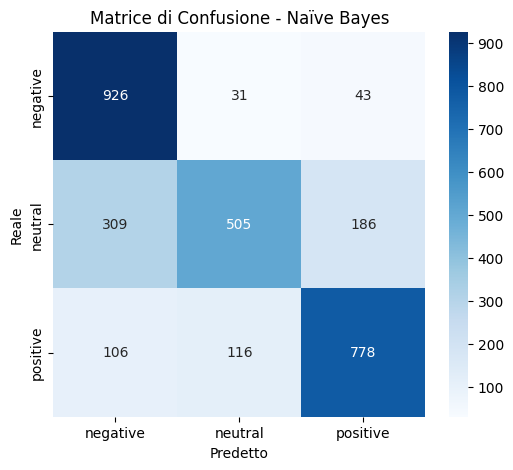

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 📌 Matrice di confusione
cm = confusion_matrix(y_test_sent, y_pred_nb)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione - Naïve Bayes")
plt.show()

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# 📌 Standardizzazione dei dati
scaler = StandardScaler(with_mean=False) # per gestire le matrici sparse geenrate da TF-IDF
X_train_scaled = scaler.fit_transform(X_train_sent)  # Usa il dataset bilanciato
X_test_scaled = scaler.transform(X_test_sent)  # Mantiene la scala nel test set

# 📌 Addestramento del modello Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=500)  # Maggiori iterazioni per stabilità
log_reg.fit(X_train_scaled, y_train_sent)

# 📌 Previsioni
y_pred_log = log_reg.predict(X_test_scaled)

# 📌 Valutazione
print("Logistic Regression Performance:")
print(classification_report(y_test_sent, y_pred_log))

Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       0.80      0.91      0.85      1000
     neutral       0.69      0.68      0.69      1000
    positive       0.76      0.67      0.71      1000

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000



## SVM

In [9]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 📌 **Standardizzazione con StandardScaler**

scaler = StandardScaler(with_mean=False)  # Evita problemi con matrici sparse TF-IDF
X_train_scaled = scaler.fit_transform(X_train_sent)
X_test_scaled = scaler.transform(X_test_sent)

# 📌 **Definizione della griglia di parametri per SVM**

param_grid = {
    'C': [0.1, 1, 10, 100],  # Parametro di regolarizzazione
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],  # Parametro di kernel
    'kernel': ['rbf', 'linear']  # Manteniamo il kernel RBF
}

# 📌 **Ricerca dei migliori iperparametri con GridSearchCV**

grid_search = GridSearchCV(
    SVC(class_weight='balanced'),
    param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1)

grid_search.fit(X_train_scaled, y_train_sent)

# 📌 **Migliori parametri trovati**
print(f"🔹 Migliori parametri trovati: {grid_search.best_params_}")

# 📌 **Usiamo il miglior modello trovato**
best_svm = grid_search.best_estimator_

# 📌 **Previsioni**
svm_predictions_rbf = best_svm.predict(X_test_scaled)

# 📌 **Valutazione del modello**
print("🔹 Report delle performance (SVM con GridSearch e StandardScaler):")
print(classification_report(y_test_sent, svm_predictions_rbf))



🔹 Migliori parametri trovati: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
🔹 Report delle performance (SVM con GridSearch e StandardScaler):
              precision    recall  f1-score   support

    negative       0.91      0.81      0.86      1000
     neutral       0.78      0.59      0.67      1000
    positive       0.64      0.86      0.73      1000

    accuracy                           0.75      3000
   macro avg       0.77      0.75      0.75      3000
weighted avg       0.77      0.75      0.75      3000



# 3. Deep learning

## Word2Vec + Padding

In [10]:
# =========================
# Word2Vec per Sentiment Analysis e Topic Detection, padding e bilanciamento
# =========================
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 📌 Caricare Word2Vec pre-addestrato
word2vec_model = api.load("word2vec-google-news-300")

# 📌 Funzione per ottenere gli embeddings di ogni parola in una frase
def get_word2vec_sequence(comment):
    tokens = word_tokenize(comment)
    vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
    return np.array(vectors, dtype=np.float32) if vectors else np.zeros((1, 300), dtype=np.float32)

# 📌 Convertire ogni commento in una sequenza di Word2Vec embeddings
word2vec_sequences = [get_word2vec_sequence(comment) for comment in df['Processed_Comment']]

# 📌 Definire la lunghezza massima per il padding
sequence_lengths = [seq.shape[0] for seq in word2vec_sequences]
optimal_length = int(np.mean(sequence_lengths) + np.std(sequence_lengths))

# 📌 Applicare il padding alle sequenze
word2vec_sequences_padded = pad_sequences(word2vec_sequences, maxlen=optimal_length, dtype='float32', padding='post', truncating='post')

# 📌 Convertire in array NumPy per TensorFlow
X_word2vec = np.array(word2vec_sequences_padded, dtype=np.float32)

# 📌 Convertire le etichette in numeri interi
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Sentiment_Numeric'] = df['Sentiment'].map(sentiment_mapping)

# 📌 Stampare la distribuzione delle classi prima del bilanciamento
print("🔹 Distribuzione classi PRIMA del bilanciamento:")
print(pd.Series(df['Sentiment_Numeric']).value_counts())

# 📌 **Appiattire il dataset per il bilanciamento**
X_word2vec_flat = X_word2vec.reshape(X_word2vec.shape[0], -1)  # Da (N, timesteps, 300) → (N, timesteps * 300)

# 📌 **Bilanciamento PRIMA della suddivisione in training e test**
# 🔹 1️⃣ **Downsampling della classe maggioritaria (`positive` → `2`)** → Ridotta a 5000 campioni
under_sampler = RandomUnderSampler(sampling_strategy={2: 5000}, random_state=42)
X_under, y_under = under_sampler.fit_resample(X_word2vec_flat, df['Sentiment_Numeric'])

# 🔹 2️⃣ **Upsampling delle classi negative (`0`) e neutrali (`1`) con SMOTE** → Portate a 5000 campioni
smote = SMOTE(sampling_strategy={0: 5000, 1: 5000}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

# 📌 Stampare la distribuzione delle classi DOPO il bilanciamento
print("\n🔹 Distribuzione classi DOPO il bilanciamento:")
print(pd.Series(y_balanced).value_counts())

# 📌 **Ripristinare la forma originale per LSTM** (N, timesteps, embedding_dim)
X_balanced = X_balanced.reshape(-1, optimal_length, 300)

# 📌 **Suddivisione del dataset bilanciato in Training e Test**
X_train_sent_seq, X_test_sent_seq, y_train_sent, y_test_sent = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# 📌 Controllare le dimensioni
print(f"Forma di X_train_sent_seq: {X_train_sent_seq.shape}")
print(f"Forma di X_test_sent_seq: {X_test_sent_seq.shape}")
print(f"Distribuzione classi train:\n{np.bincount(y_train_sent)}")
print(f"Distribuzione classi test:\n{np.bincount(y_test_sent)}")

: 

### LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# =========================
# 📌 Creazione del modello LSTM ottimizzato per evitare overfitting
# =========================

lstm_model = Sequential([
    Masking(mask_value=0.0, input_shape=(optimal_length, 300)),  # Ignora i padding
    LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),  # 🔹 Dropout nella LSTM
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),  # 🔹 Strato LSTM più piccolo
    Dropout(0.3),  # 🔹 Dropout tra le LSTM e il Dense
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # 🔹 L2 Regularization
    Dropout(0.3),  # 🔹 Dropout anche nel Fully Connected
    Dense(3, activation='softmax')  # 🔹 Output con 3 classi
])

"""lstm_model = Sequential([
    Masking(mask_value=0.0, input_shape=(optimal_length, 300)),  # Ignora i padding
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])"""

# 📌 Compilazione del modello
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 📌 Calcolo dei pesi delle classi
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_sent), y=y_train_sent)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 📌 Early Stopping con patience maggiore
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# 📌 Addestramento con batch_size maggiore
history = lstm_model.fit(X_train_sent_seq, y_train_sent,
                         epochs=20,  # 🔹 Aumentato per stabilità
                         batch_size=64,  # 🔹 Batch più grande per aggiornamenti più stabili
                         validation_data=(X_test_sent_seq, y_test_sent),
                         callbacks=[early_stopping])  # 🔹 Usare pesi di classe

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.4921 - loss: 1.2542 - val_accuracy: 0.7270 - val_loss: 0.7820
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7021 - loss: 0.8221 - val_accuracy: 0.7343 - val_loss: 0.6931
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7156 - loss: 0.7300 - val_accuracy: 0.7543 - val_loss: 0.6414
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.7303 - loss: 0.6936 - val_accuracy: 0.7530 - val_loss: 0.6156
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7312 - loss: 0.6670 - val_accuracy: 0.7680 - val_loss: 0.6009
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.7411 - loss: 0.6463 - val_accuracy: 0.7577 - val_loss: 0.5978
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.7498 - loss: 0.6404 - val_accuracy: 0.7727 - val_loss: 0.5794
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.7522 - loss: 0.6222 -

## Grafico di Accuracy e Loss durante l’addestramento

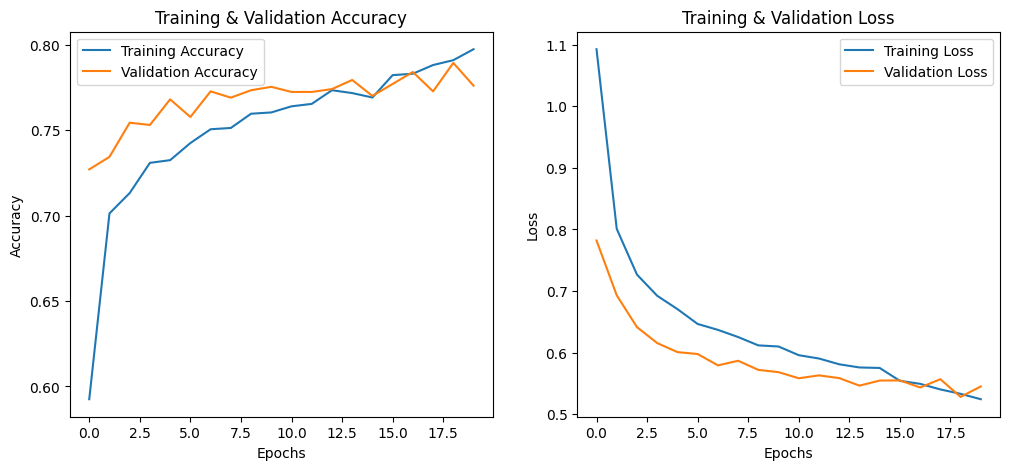

In [ ]:
# 📌 Ottenere i dati dall'addestramento
history = lstm_model.history.history

# 📌 Plot della accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 📌 Plot della loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Precision, Recall, F1-score

In [ ]:
from sklearn.metrics import classification_report

# 📌 Previsioni sul test set
y_pred_lstm = np.argmax(lstm_model.predict(X_test_sent_seq), axis=1)  # Converte probabilità in classi

# 📌 Generare il classification report
report = classification_report(y_test_sent, y_pred_lstm, target_names=['negative', 'neutral', 'positive'])

# 📌 Stampare il report
print("LSTM Performance:\n", report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
LSTM Performance:
               precision    recall  f1-score   support

    negative       0.80      0.84      0.82      1000
     neutral       0.73      0.72      0.73      1000
    positive       0.84      0.80      0.82      1000

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



## Matrice di Confusione

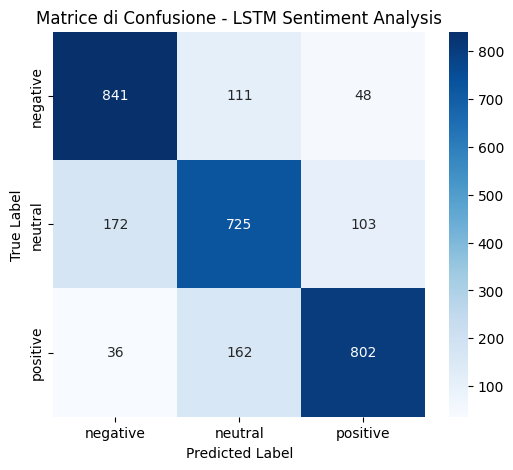

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 📌 Creare la matrice di confusione
cm = confusion_matrix(y_test_sent, y_pred_lstm)

# 📌 Plot della matrice di confusione
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matrice di Confusione - LSTM Sentiment Analysis")
plt.show()

## Transformer

In [8]:
import torch

# Controllare la disponibilità della GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [ ]:
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, classification_report

# 📌 Controllare e impostare il dispositivo su GPU CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔹 Using device: {device}")

# 📌 Mappare i sentimenti in numeri
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Sentiment_Numeric'] = df['Sentiment'].map(sentiment_mapping)

# 📌 Stampare la distribuzione delle classi PRIMA del bilanciamento
print("🔹 Distribuzione classi PRIMA del bilanciamento:")
print(df['Sentiment_Numeric'].value_counts())

# 📌 Suddividere il dataset bilanciato in training e test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Processed_Comment'].tolist(), df['Sentiment_Numeric'].tolist(),
    test_size=0.2, stratify=df['Sentiment_Numeric'], random_state=42
)

# 📌 Caricare il Tokenizer di BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 📌 Tokenizzare i testi per BERT
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=70, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=70, return_tensors='pt')

# 📌 Convertire gli encodings in NumPy per poter applicare SMOTE
X_train = train_encodings['input_ids'].numpy()
y_train = np.array(train_labels)

# 📌 **Bilanciamento Dopo la Tokenizzazione**
# 🔹 1️⃣ **Downsampling della classe `positive` (2) → Ridotta a 5000 campioni**
under_sampler = RandomUnderSampler(sampling_strategy={2: 5000}, random_state=42)
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

# 🔹 2️⃣ **Upsampling delle classi `negative` (0) e `neutral` (1) con SMOTE → Portate a 5000 campioni**
smote = SMOTE(sampling_strategy={0: 5000, 1: 5000}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

# 📌 Stampare la distribuzione delle classi DOPO il bilanciamento
print("\n🔹 Distribuzione classi DOPO il bilanciamento:")
print(pd.Series(y_balanced).value_counts())

# 📌 **Convertire i dati bilanciati in Tensor per PyTorch**
X_balanced_tensor = torch.tensor(X_balanced, dtype=torch.long)
y_balanced_tensor = torch.tensor(y_balanced, dtype=torch.long)

# 📌 **Classe Dataset Corretto**
class SentimentDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {"input_ids": self.input_ids[idx], "labels": self.labels[idx]}

# 📌 Creazione dei dataset
train_dataset = SentimentDataset(X_balanced_tensor, y_balanced_tensor)
test_dataset = SentimentDataset(test_encodings["input_ids"], torch.tensor(test_labels))

# 📌 Configura BERT con dropout più alto
config = BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

# 📌 Caricare il modello pre-addestrato di BERT per classificazione
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.to(device)

# 📌 Definire l'ottimizzatore AdamW con weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=10)

# 📌 Aumentare il batch size per sfruttare la GPU
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 📌 Funzione di Training Personalizzata
def train_model(model, train_loader, val_loader, epochs=10):
    class_weights = torch.tensor([1.0 / 0.33, 1.0 / 0.33, 1.0 / 0.33]).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    results = []
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, leave=True)
        total_loss = 0
        start_time = time.time()

        for batch in loop:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(input_ids=inputs["input_ids"])
            loss = loss_fn(outputs.logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()
            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item())

        avg_training_loss = total_loss / len(train_loader)
        val_loss, val_accuracy = evaluate_model(model, val_loader)
        epoch_time = time.time() - start_time

        results.append({
            "Epoca": f"Epoca {epoch + 1}",
            "Training Loss": round(avg_training_loss, 4),
            "Validation Loss": round(val_loss, 4),
            "Validation Accuracy": round(val_accuracy, 4),
            "Training Time": time.strftime("%H:%M:%S", time.gmtime(epoch_time))
        })

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# 📌 Funzione di Valutazione
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(input_ids=inputs["input_ids"])
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_loss / len(val_loader)
    accuracy = correct / total
    return avg_val_loss, accuracy

# 📌 Avviare l'addestramento
results_df = train_model(model, train_loader, val_loader, epochs=10)

# 📌 Salva il DataFrame con i risultati
results_df.to_csv("training_results.csv", index=False)

# 📌 Valutazione sul set di test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].cpu().numpy()

        outputs = model(input_ids=inputs["input_ids"])
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# 📌 Salva le previsioni e i veri label
np.save("predictions.npy", np.array(all_preds))
np.save("true_labels.npy", np.array(all_labels))

🔹 Using device: cuda
🔹 Distribuzione classi PRIMA del bilanciamento:
Sentiment_Numeric
2    11402
1     4625
0     2337
Name: count, dtype: int64

🔹 Distribuzione classi DOPO il bilanciamento:
0    5000
1    5000
2    5000
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 10: 100%|██████████| 469/469 [03:19<00:00,  2.35it/s, loss=0.357]


      Epoca  Training Loss  Validation Loss  Validation Accuracy Training Time
0   Epoca 1         0.9621           0.8418               0.6676      00:03:36
1   Epoca 2         0.7510           0.5559               0.7836      00:03:35
2   Epoca 3         0.6457           0.4988               0.8053      00:03:35
3   Epoca 4         0.6102           0.4928               0.8056      00:03:35
4   Epoca 5         0.5751           0.4925               0.8051      00:03:35
5   Epoca 6         0.5522           0.4738               0.8154      00:03:35
6   Epoca 7         0.5314           0.4627               0.8211      00:03:35
7   Epoca 8         0.5280           0.4821               0.8143      00:03:35
8   Epoca 9         0.4988           0.4643               0.8312      00:03:35
9  Epoca 10         0.4858           0.4468               0.8307      00:03:35


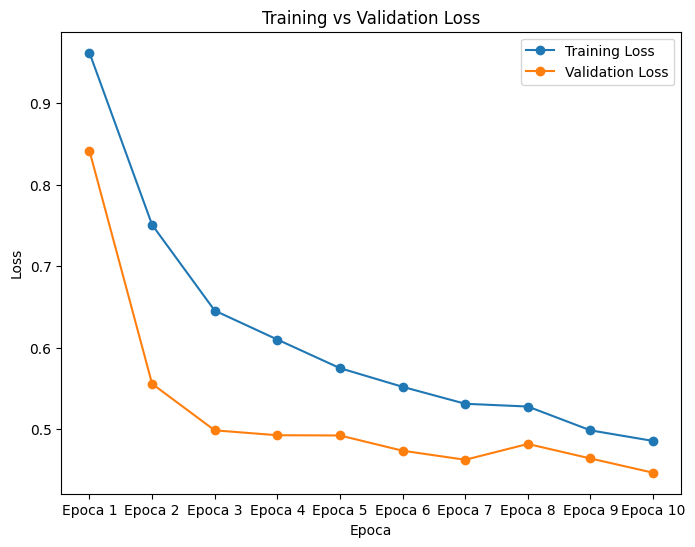

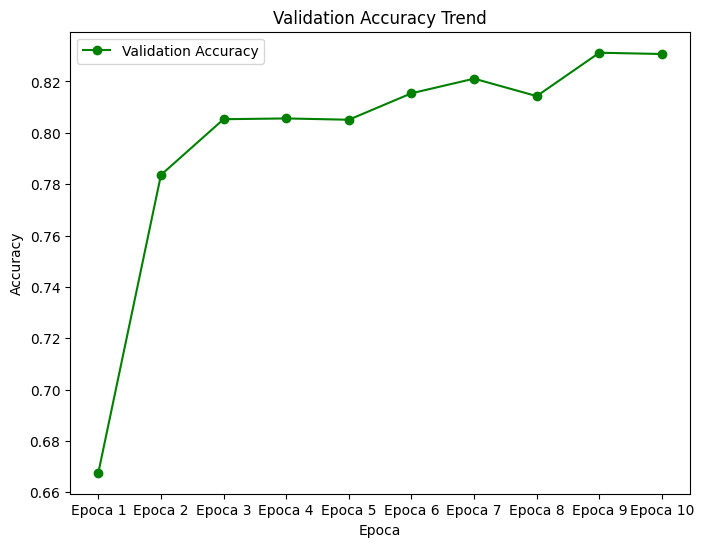

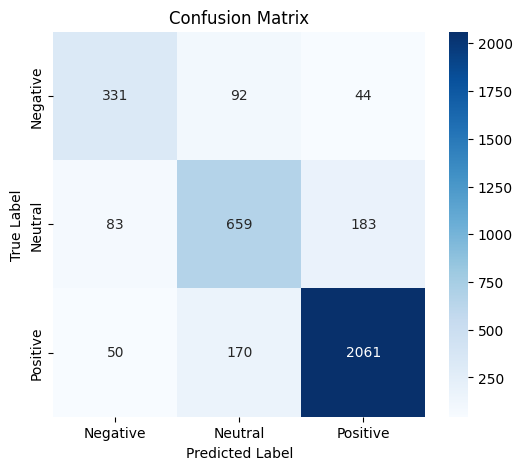


Classification Report:

              precision    recall  f1-score   support

    Negative       0.71      0.71      0.71       467
     Neutral       0.72      0.71      0.71       925
    Positive       0.90      0.90      0.90      2281

    accuracy                           0.83      3673
   macro avg       0.78      0.77      0.78      3673
weighted avg       0.83      0.83      0.83      3673



In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 📌 Carica i dati salvati
results_df = pd.read_csv("training_results.csv")
all_preds = np.load("predictions.npy")
all_labels = np.load("true_labels.npy")

# 📌 Grafico Loss durante il Training
plt.figure(figsize=(8, 6))
plt.plot(results_df["Epoca"], results_df["Training Loss"], label="Training Loss", marker="o")
plt.plot(results_df["Epoca"], results_df["Validation Loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# 📌 Grafico Accuracy durante il Training
plt.figure(figsize=(8, 6))
plt.plot(results_df["Epoca"], results_df["Validation Accuracy"], label="Validation Accuracy", marker="o", color="green")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Trend")
plt.show()

# 📌 Matrice di Confusione
cm = confusion_matrix(all_labels, all_preds)
labels = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📌 Report di Classificazione
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=labels))


